In [80]:
!pip install quandl QuantLib quantstats optionlab yoptions yfinance pandas_datareader seaborn

In [81]:
# Import necessary libraries
import yfinance as yf
import yoptions as yo
import optionlab as ol

import pandas as pd
import numpy as np

import pandas_datareader.data as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# Define the time period
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.now()  # This will set the end date to today's date

# Ensure to use the date component only if necessary
end = end.date()  # Converts datetime object to a date object, removing time component if not needed

## Getting Options Data

In [100]:
# Function to fetch option Greeks for given strikes
def get_option_greeks_for_strikes(ticker, strikes):
    # Get the options data for the given ticker
    stock = yf.Ticker(ticker)
    options_data = {}

    # Iterate through expiration dates and strikes
    for expiration in stock.options:
        opt = stock.option_chain(expiration)
        all_options = pd.concat([opt.calls, opt.puts])
        selected_options = all_options[all_options['strike'].isin(strikes)]
        
        # Fetch the Greeks for the selected options
        for index, row in selected_options.iterrows():
            greeks = (row['delta'], row['gamma'], row['theta'], row['vega'], row['rho'])
            strike = row['strike']
            options_data[strike] = greeks

    return options_data

def get_daily_woodies_pivots_with_bollinger(ticker, start_date, end_date, window=20, no_of_stds=2, strike_increment=1):
    # Fetch historical daily data
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # Calculate Bollinger Bands
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    data['Bollinger High'] = rolling_mean + (rolling_std * no_of_stds)
    data['Bollinger Low'] = rolling_mean - (rolling_std * no_of_stds)
    

    # Calculate Woodie's pivot points
    data['Pivot Point'] = (data['High'] + data['Low'] + 2 * data['Close']) / 4
    data['R1'] = 2 * data['Pivot Point'] - data['Low']
    data['S1'] = 2 * data['Pivot Point'] - data['High']
    data['R2'] = data['Pivot Point'] + (data['High'] - data['Low'])     
    data['S2'] = data['Pivot Point'] - (data['High'] - data['Low'])
    data['R3'] = data['Pivot Point'] + 2 * (data['High'] - data['Low'])
    data['S3'] = data['Pivot Point'] - 2 * (data['High'] - data['Low']) 
    data['R4'] = data['Pivot Point'] + 3 * (data['High'] - data['Low'])

    # Round Bollinger Bands and pivot points to the nearest strike
    rounding_columns = ['Bollinger High', 'Bollinger Low', 'Pivot Point', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3', 'R4']
    for column in rounding_columns:
        data[column + '_Strike'] = np.round(data[column] / strike_increment) * strike_increment

    # Spreads between the pivot points
    data['Bearcall_Spread_width'] = data['R1_Strike'] - data['Pivot Point_Strike']
    data['Bullput_Spread_width'] = data['Pivot Point_Strike'] - data['S1_Strike']
    
    data['Bearcall_Spread_width_2'] = data['R2_Strike'] - data['Pivot Point_Strike']
    data['Bullput_Spread_width_2'] = data['Pivot Point_Strike'] - data['S2_Strike']
    
    data['Bearcall_Spread_width_3'] = data['R3_Strike'] - data['Pivot Point_Strike']
    data['Bullput_Spread_width_3'] = data['Pivot Point_Strike'] - data['S3_Strike']

    data['BB_Spread'] = data['Bollinger High_Strike'] - data['Bollinger Low_Strike']

    # Percentage change for the spread
    # data['Bearcall_Spread_Percentage'] = data['Bearcall_Spread_width'] / data['Close']
    # data['Bullput_Spread_Percentage'] = data['Bullput_SBullput_Spread_widthpread_'] / data['Close']
    
    return data

# Define the ticker symbol
Strikes = get_daily_woodies_pivots_with_bollinger('AAPL', start, end) 
print(Strikes.tail(10))

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-16  136.690002  137.649994  133.729996  134.509995  133.591843   
2022-12-19  135.110001  135.199997  131.320007  132.369995  131.466476   
2022-12-20  131.389999  133.250000  129.889999  132.300003  131.396957   
2022-12-21  132.979996  136.809998  132.750000  135.449997  134.525436   
2022-12-22  134.350006  134.559998  130.300003  132.229996  131.327423   
2022-12-23  130.919998  132.419998  129.639999  131.860001  130.959961   
2022-12-27  131.380005  131.410004  128.720001  130.029999  129.142456   
2022-12-28  129.669998  131.029999  125.870003  126.040001  125.179680   
2022-12-29  127.989998  130.479996  127.730003  129.610001  128.725311   
2022-12-30  128.410004  129.949997  127.430000  129.929993  129.043121   

               Volume  Bollinger High  Bollinger Low  Pivot Point          R1  \
Date                          

## Visualize R1 Stikes

### Plotting Spreads

Text(0.5, 1.0, 'Box Plot of Spreads')

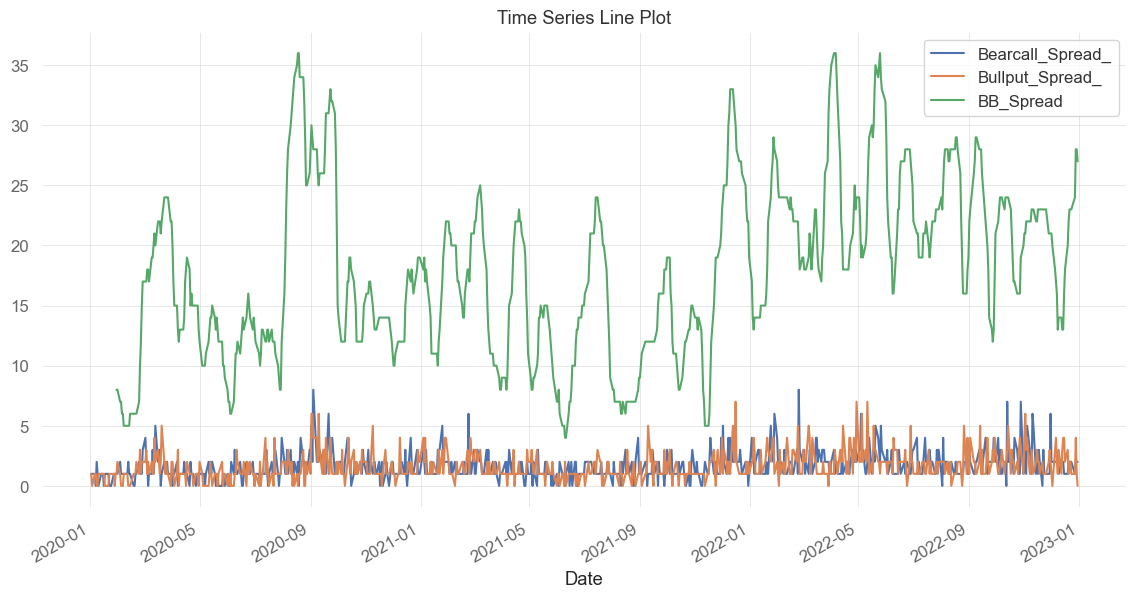

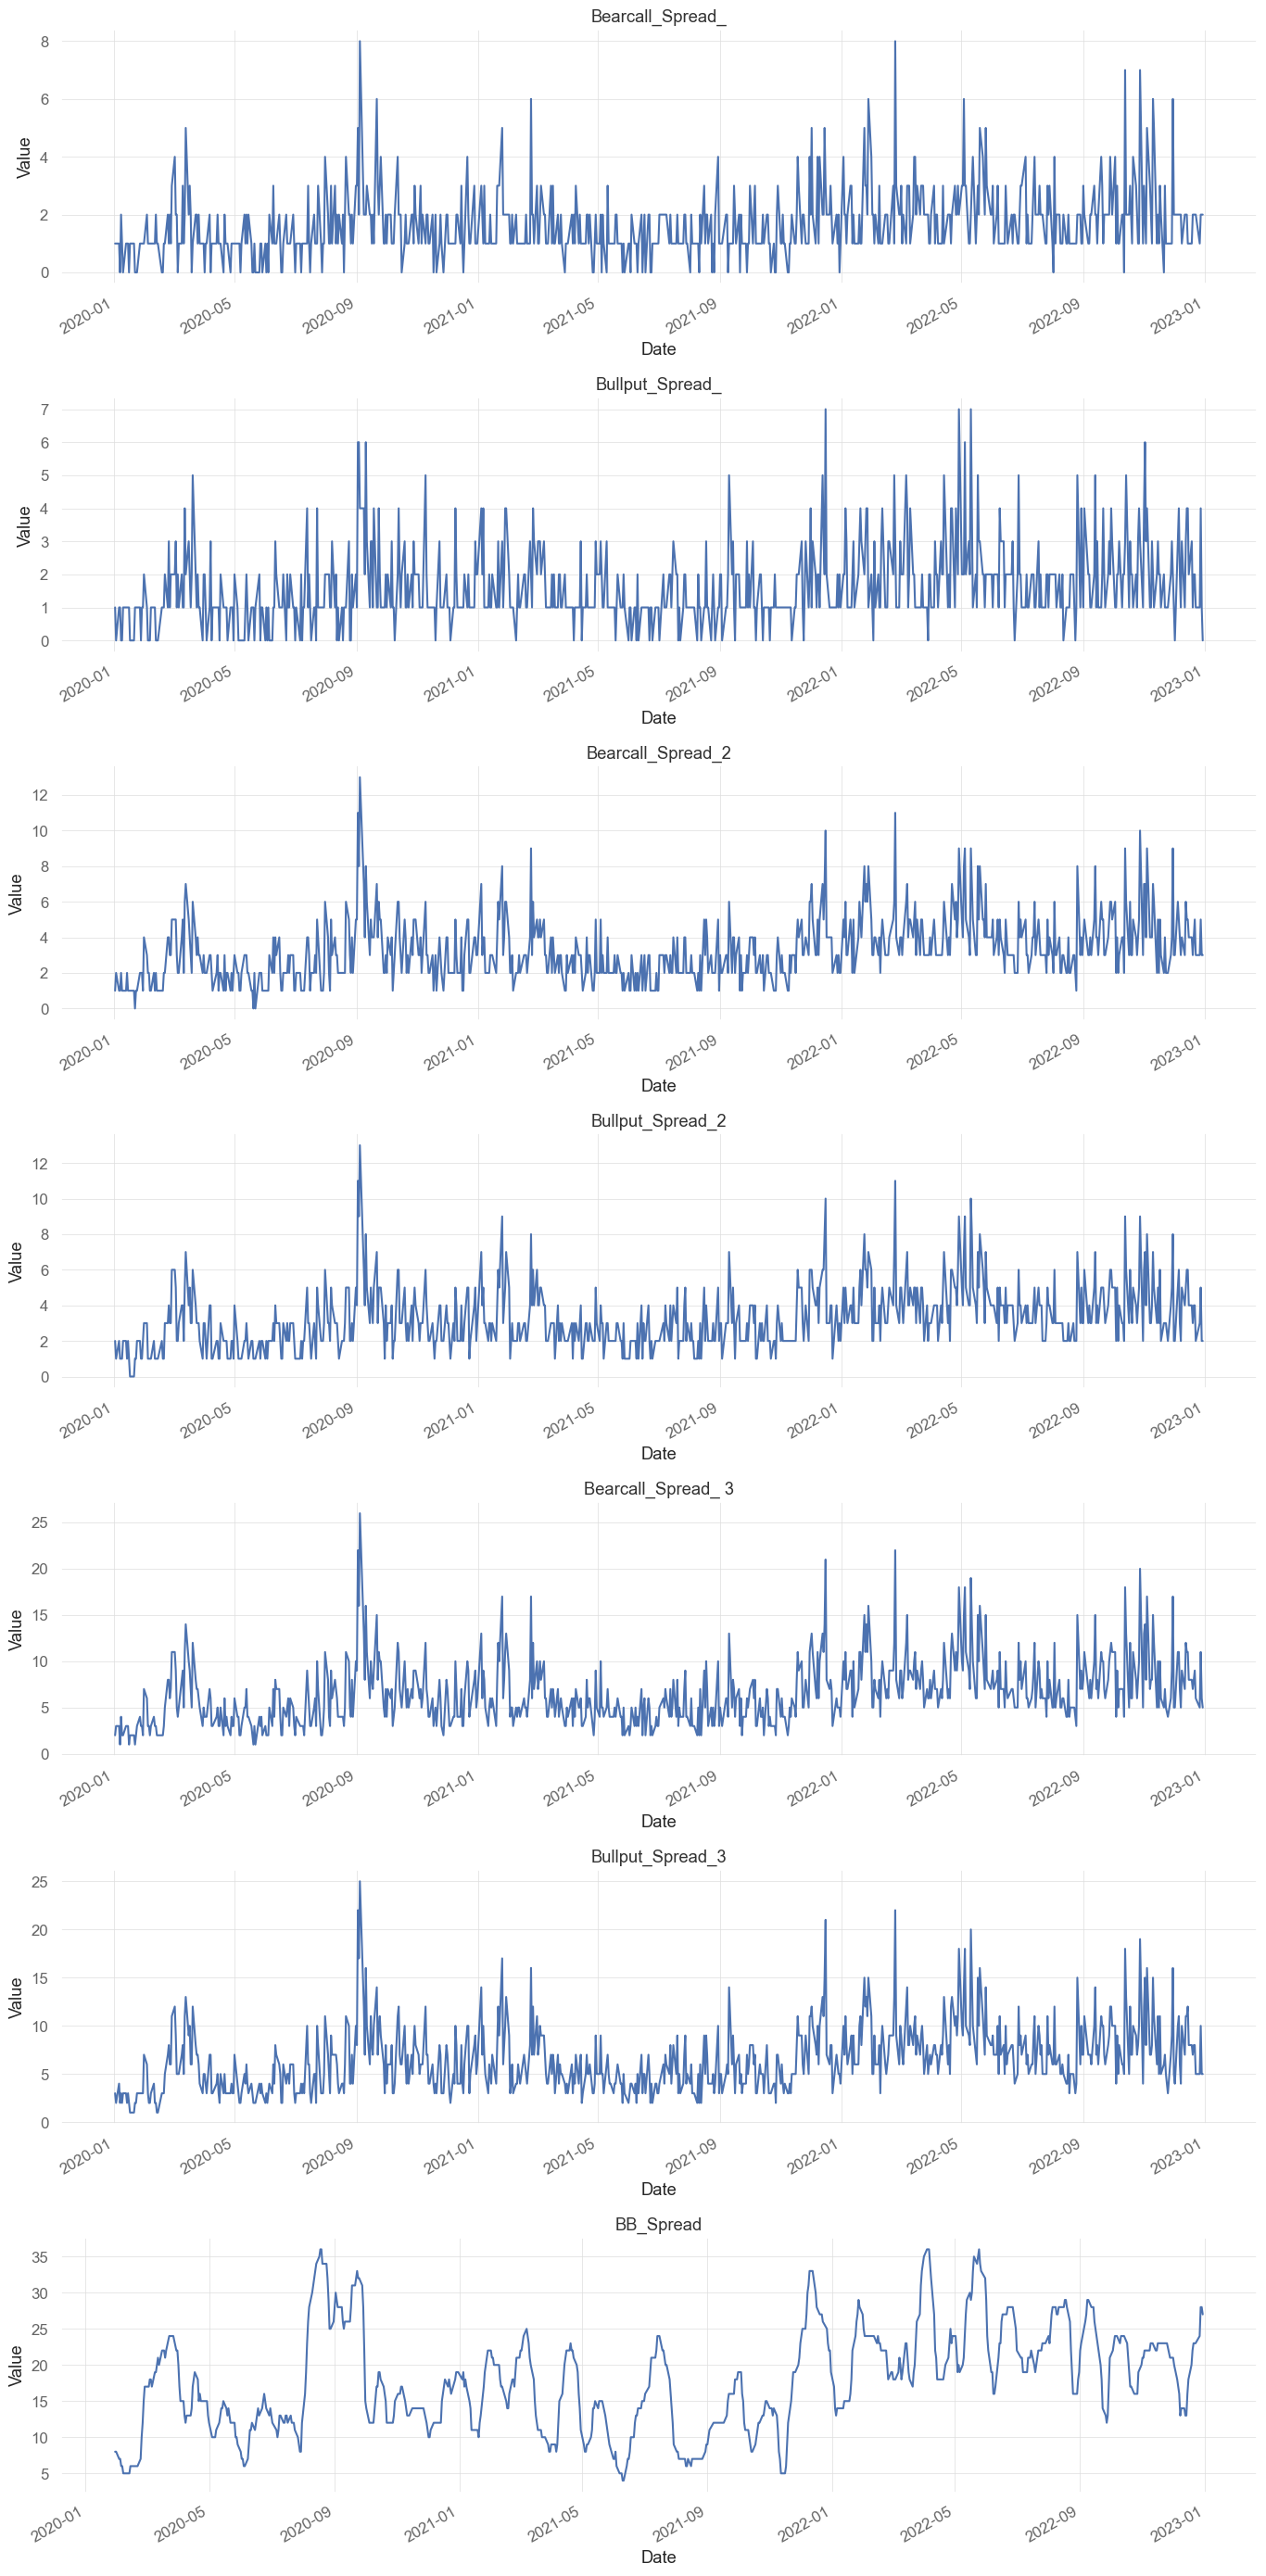

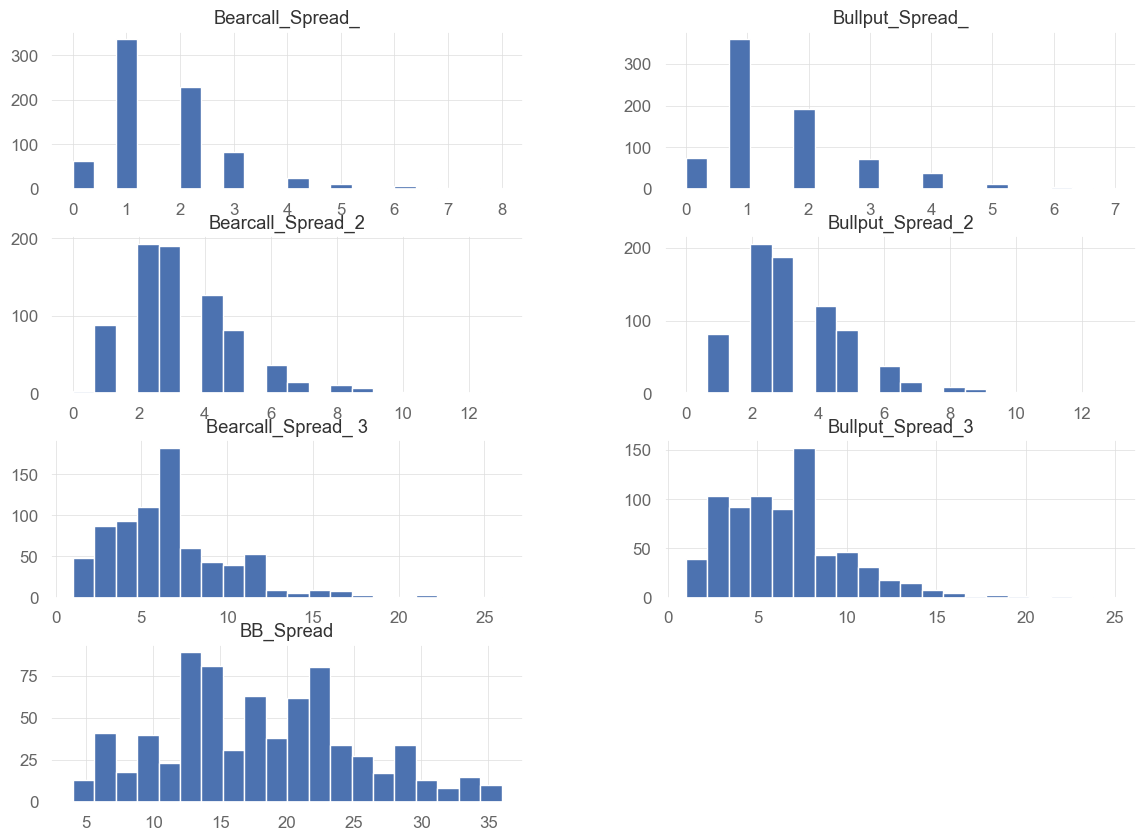

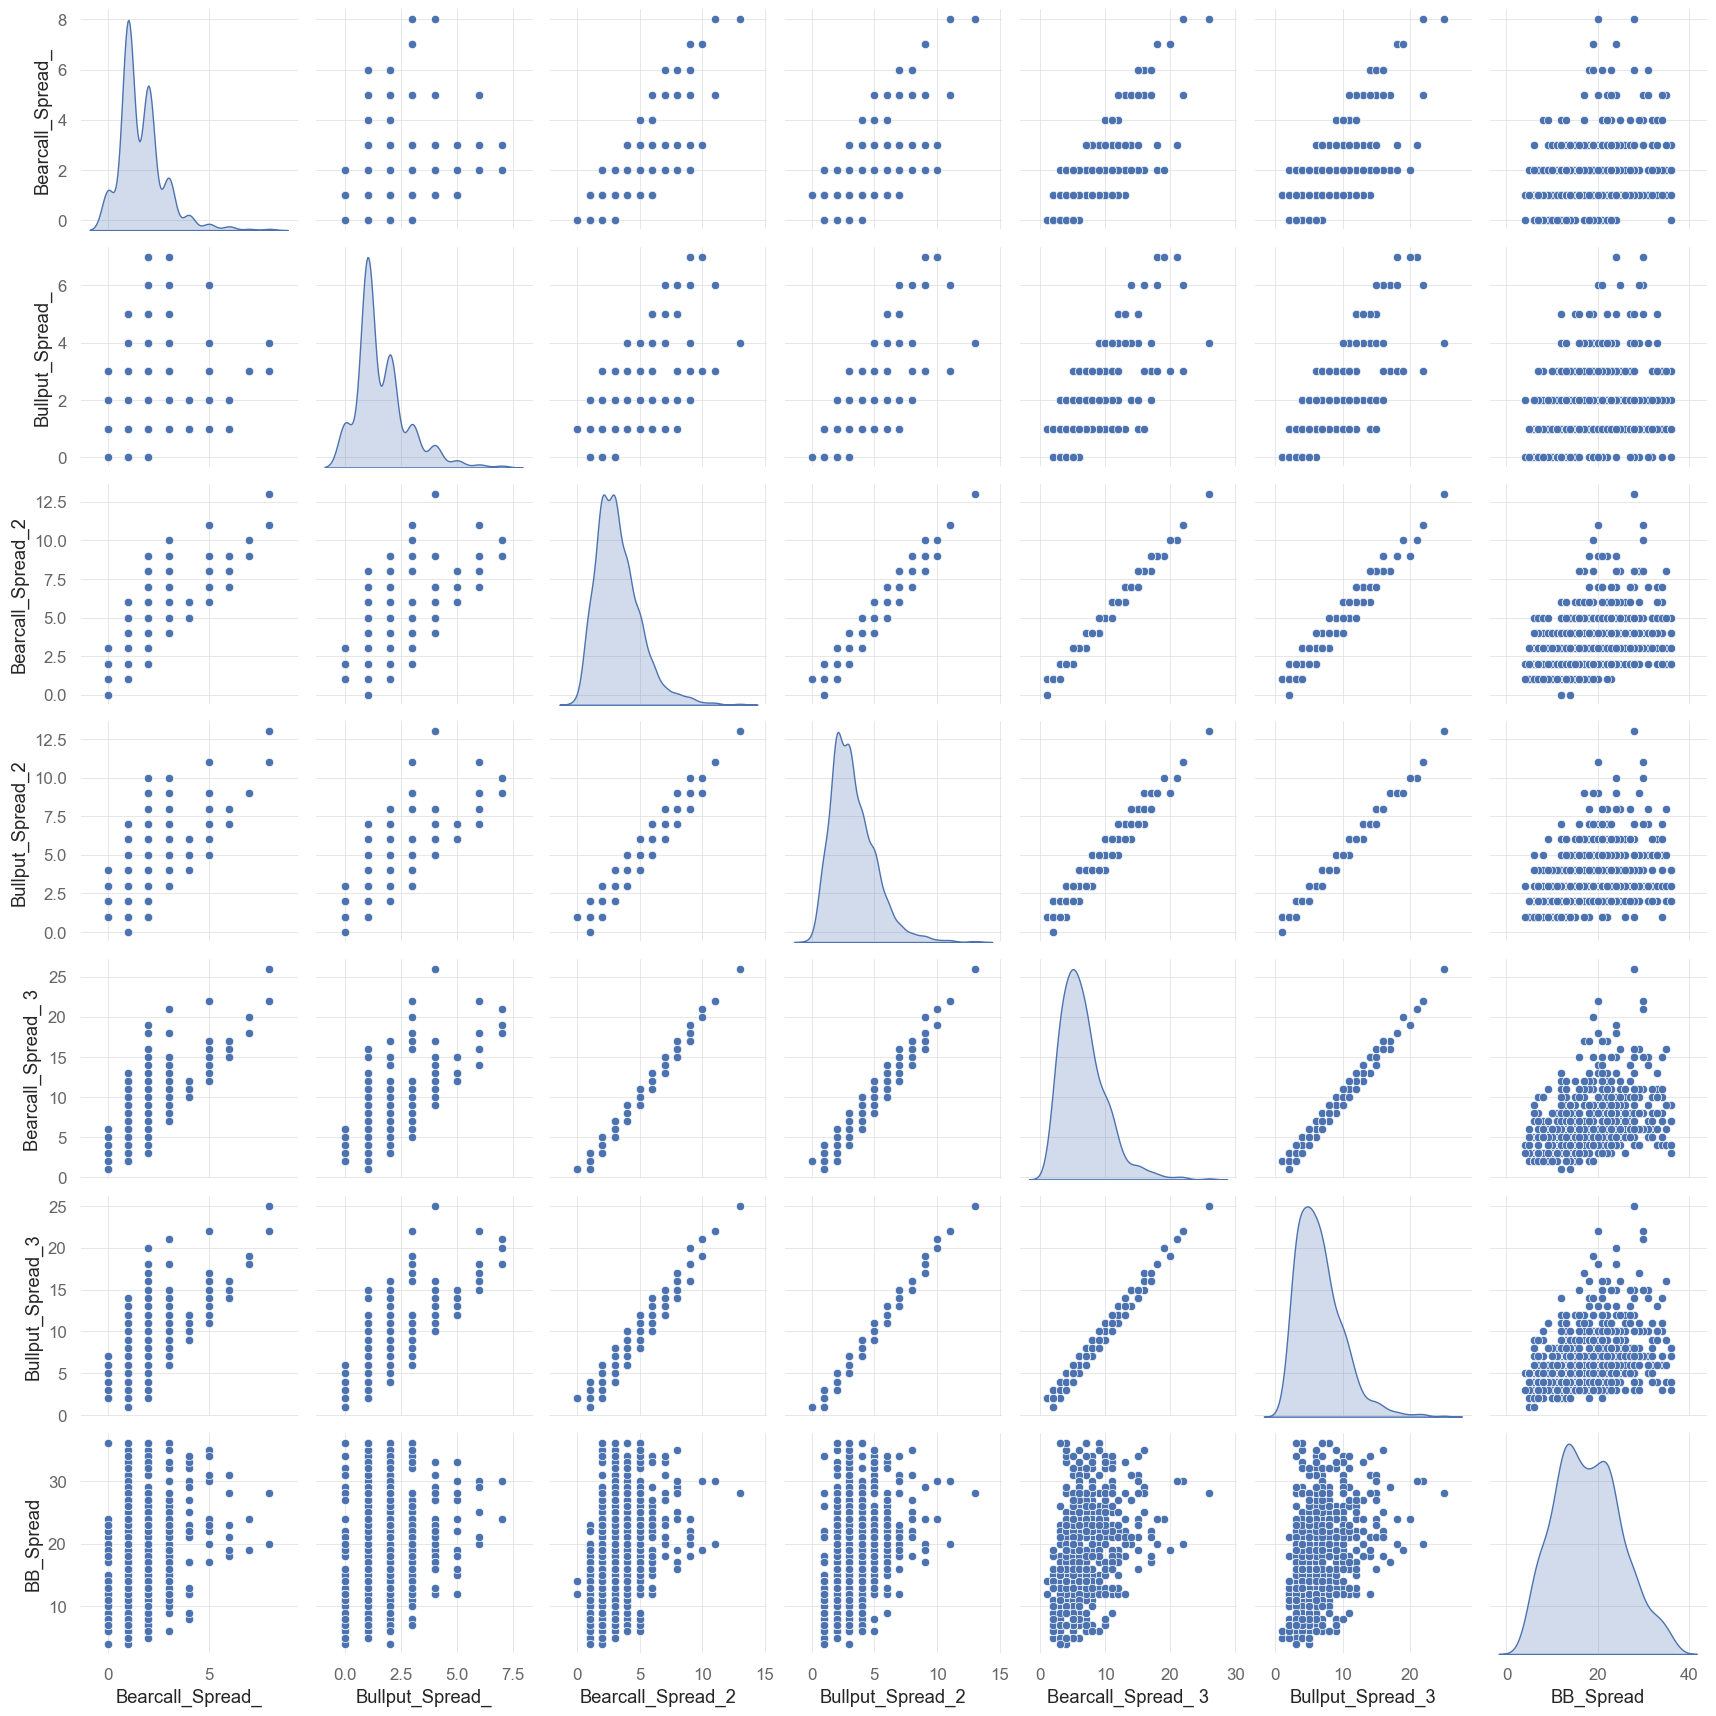

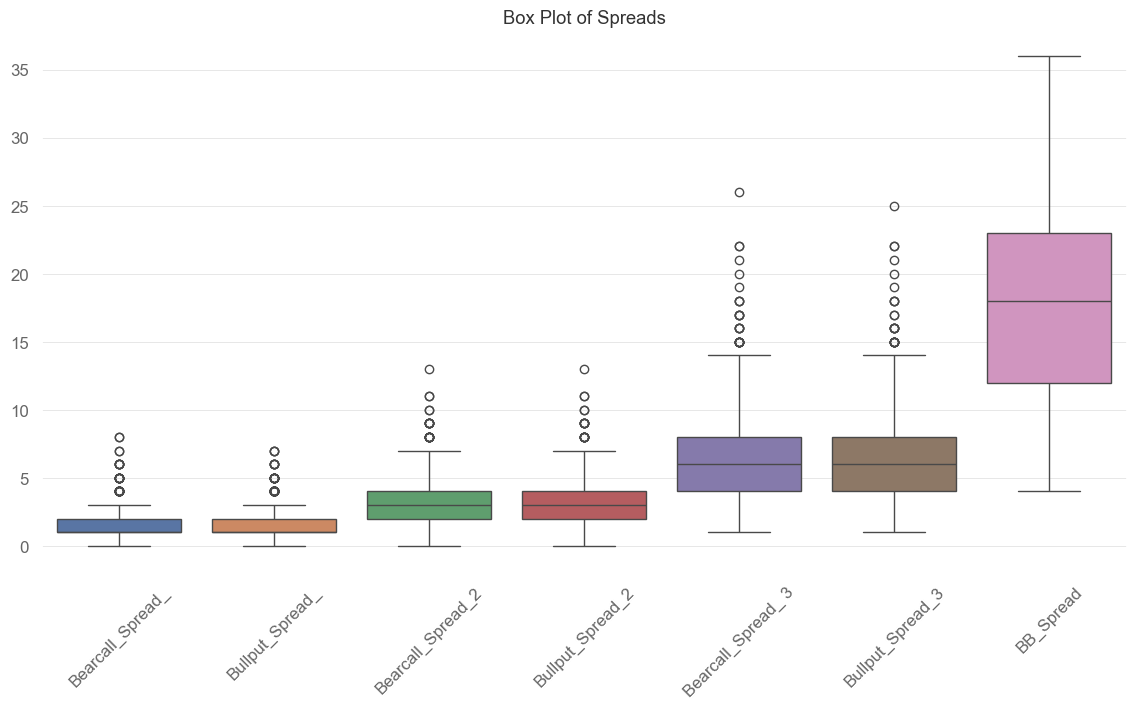

In [90]:
### Plotting Spreads
def plot_spreads(data):
    """
    Plots the calculated bear call spreads, bull put spreads, and Bollinger Bands spread.

    Args:
    data (pandas.DataFrame): DataFrame containing the calculated spreads.
    """
    # Plot settings
    plt.figure(figsize=(14, 7))
    plt.title(f"Spreads for {ticker}")

    # Plot each of the spreads
    plt.plot(data.index, data['Bearcall_Spread_'], label='Bear Call Spread (R1 - Pivot)')
    plt.plot(data.index, data['Bullput_Spread_'], label='Bull Put Spread (Pivot - S1)')
    plt.plot(data.index, data['Bearcall_Spread_2'], label='Bear Call Spread 2 (R2 - Pivot)')
    plt.plot(data.index, data['Bullput_Spread_2'], label='Bull Put Spread 2 (Pivot - S2)')
    plt.plot(data.index, data['Bearcall_Spread_ 3'], label='Bear Call Spread 3 (R3 - Pivot)')
    plt.plot(data.index, data['Bullput_Spread_3'], label='Bull Put Spread 3 (Pivot - S3)')
    plt.plot(data.index, data['BB_Spread'], label='Bollinger Bands Spread')

    # Labels and legend
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

# Define the ticker symbol
ticker = 'AAPL'
start = '2020-01-01'
end = '2023-01-01'

# 1. Time Series Line Plot
Strikes[['Bearcall_Spread_', 'Bullput_Spread_', 'BB_Spread']].plot(figsize=(14, 7), title='Time Series Line Plot')

# 2. Subplots for Each Spread
spread_columns = ['Bearcall_Spread_', 'Bullput_Spread_', 'Bearcall_Spread_2', 'Bullput_Spread_2', 'Bearcall_Spread_ 3', 'Bullput_Spread_3', 'BB_Spread']
fig, axes = plt.subplots(nrows=len(spread_columns), ncols=1, figsize=(14, 4 * len(spread_columns)))
for i, col in enumerate(spread_columns):
    Strikes[col].plot(ax=axes[i], title=col)
    axes[i].set_ylabel('Value')
plt.tight_layout()

# 3. Histograms of Spread Distributions
Strikes[spread_columns].hist(bins=20, layout=(4, 2), figsize=(14, 10))

# 4. Scatter Plot Matrix
sns.pairplot(Strikes[spread_columns], diag_kind='kde')

# 5. Candlestick Chart with Overlays
# This would be more complex and would involve plotting the candlestick chart with mplfinance

# 6. Box Plots for Spread Comparison
plt.figure(figsize=(14, 7))
sns.boxplot(data=Strikes[spread_columns])
plt.xticks(rotation=45)
plt.title('Box Plot of Spreads')

##### Interpretation

Time Series Line Plots (First Image):

These plots show the fluctuation of the Bearcall and Bullput spreads over time.
Sharp spikes can indicate periods of high volatility or market reactions to events.
Persistent levels above or below a certain threshold could signal new market regimes or persistent conditions affecting option prices.
Histograms (Second Image):

Histograms reveal the distribution of values for each spread.
The shape and spread of the histograms can inform about the commonality of different spread sizes.
A spread with a narrow histogram suggests less variability, while a wide histogram suggests greater uncertainty in spread size.
Scatter Plot Matrix (Third Image):

This matrix shows correlations between different spreads.
Diagonal plots are the density estimates for each spread and provide a sense of the distribution.
Off-diagonal plots show whether there's a linear relationship between the spreads; the tighter the points cluster around a line, the stronger the relationship.
Box Plots (Fourth Image):

Box plots visualize the central tendency and dispersion of the spreads.
The 'whiskers' show the range of the data, with points outside representing outliers.
The width of the boxes indicates the interquartile range (IQR), offering a quick sense of spread variability.
General Interpretations:

If the Bearcall spreads are consistently higher than the Bullput spreads, this may suggest that the market is assigning a higher probability to upward movement or vice versa.
The BB_Spread indicates the volatility of the underlying. A wider BB_Spread may correlate with higher option premiums due to increased volatility.
When comparing these visuals together, a quant would look for patterns or anomalies that might suggest trading opportunities or risks that are not priced into the market.
For an iron condor strategy, a quant would prefer stable and predictable spreads, as this strategy profits from the underlying price staying within a certain range.
By examining the relationships between the different spreads and their respective volatilities (as indicated by BB_Spread), a quant can gauge the market sentiment and structure trades that have a higher probability of yielding returns while managing risk.




In [85]:
"""
Call Strike Above Resistance: A call strike above a high resistance level (like R1 or R2) that the stock is unlikely to breach.
Put Strike Below Support: A put strike below a significant support level (like S1 or S2) that the stock is unlikely to drop below.
Consider Bollinger Bands: Choose strikes outside the Bollinger Bands, as they represent a range where the price stays with a high probability.
Consider Liquidity and Open Interest: While the script doesn't provide this data, in practice, you should also consider the liquidity and open interest of the options to ensure you can enter and exit the trades with minimal slippa


    # # Bullput spread
    # data['Bullput Spread'] = data['Pivot Point_Strike'] - data['S1_Strike']

    # # Bearcall spread
    # data['Bearcall Spread'] = data['R1_Strike'] - data['Pivot Point_Strike']

    # Butterfly spread

    # data['Butterfly Spread'] = data['R1_Strike'] - data['S1_Strike']

    # Long Synthetic Future

    # Short Synthetic Future

    # Bull Put Ladder

    # Bear Call Ladder

    # Iron Condor

"""



def get_high_prob_iron_condor_strikes(data, strike_increment):
    """
    An iron condor is a neutral strategy that is profitable if the stock remains within the inner strikes B and C.
    It is established for a net credit and has a wider profitable range than an iron butterfly, but the potential profit is lower.
    Decreasing volatility will increase the profitable area and chance of profit, while increasing volatility will narrow the profitable range. 
    Time is helpful when the position is profitable, and harmful when it isn't.
    This means, they are ideal for range-bound markets with low volatility, partivularly when rates are expected to remain stable for long durations...
    Consequently, its important to consider the following points when selecting the strikes for an Iron Condor strategy:
    1. THe Asset Class has relatively low volatility.
    2. Forcasting should be used to predict fed rates and violatility
    3. Violatility stop-losses should be used to manage risk.


    In order to select the strikes for an Iron Condor strategy, we can consider the following steps:
    1. Find the furthest rounded resistance (call) and support (put) levels.
    2. Choose strikes for the call side outside of Bollinger Band or resistance.
    3. Choose strikes for the put side outside of Bollinger Band or support.
    4. Ensure the long strikes are further out for safety.
    5. Return the chosen strikes for the Iron Condor strategy.
    
    Selects four high-probability strike prices for an Iron Condor options strategy.

    Args:
    data (pandas.DataFrame): Dataframe containing the calculated fields.
    strike_increment (int): Increment to round the pivot points to.

    Returns:
    dict: Dictionary with chosen strikes for the Iron Condor strategy.
    """
    # Find the furthest rounded resistance (call) and support (put) levels
    highest_resistance = max([data['R1_Strike'].iloc[-1], data['R2_Strike'].iloc[-1], data['R3_Strike'].iloc[-1]])
    lowest_support = min([data['S1_Strike'].iloc[-1], data['S2_Strike'].iloc[-1], data['S3_Strike'].iloc[-1]])
    
    # Bollinger Bands could be used to choose the furthest strikes as well
    upper_bb = data['Bollinger High_Strike'].iloc[-1]
    lower_bb = data['Bollinger Low_Strike'].iloc[-1]
    
    # Choose strikes for call side outside of Bollinger Band or resistance
    short_call_strike = max(highest_resistance, upper_bb) + strike_increment
    long_call_strike = short_call_strike + 2 * strike_increment  # Further out for safety
    
    # Choose strikes for put side outside of Bollinger Band or support
    short_put_strike = min(lowest_support, lower_bb) - strike_increment
    long_put_strike = short_put_strike - 2 * strike_increment  # Further out for safety
    
    return {
        'short_call_strike': short_call_strike,
        'long_call_strike': long_call_strike,
        'short_put_strike': short_put_strike,
        'long_put_strike': long_put_strike
    }

# Call the function with the latest data
Strikes = get_daily_woodies_pivots_with_bollinger('AAPL', '2020-01-01', '2023-01-01')
iron_condor_strikes = get_high_prob_iron_condor_strikes(Strikes, 1)
print(iron_condor_strikes)


[*********************100%%**********************]  1 of 1 completed

{'short_call_strike': 152.0, 'long_call_strike': 154.0, 'short_put_strike': 123.0, 'long_put_strike': 121.0}


In [9]:




# Function to fetch daily data and calculate pivot point
def fetch_and_calculate_pivot(ticker):
    # Fetch historical data
    data = yf.download(ticker, period="5d", interval="1d")  # Last 5 days
    last_day = data.iloc[-1]  # Get the last available day
    # Calculate pivot point
    pivot_point = (last_day['High'] + last_day['Low'] + last_day['Close']) / 3
    return pivot_point, last_day.name.date()  # Return the pivot point and the date

# Function to fetch options data and find closest strike
def find_closest_strike_option(ticker, pivot_point):
    stock = yf.Ticker(ticker)
    options = stock.option_chain()  # Fetch options data
    calls = options.calls
    puts = options.puts
    # Find the strike closest to the pivot point
    closest_call_strike = calls.iloc[(calls['strike'] - pivot_point).abs().argsort()[:1]]
    closest_put_strike = puts.iloc[(puts['strike'] - pivot_point).abs().argsort()[:1]]
    return closest_call_strike, closest_put_strike

# Get the data for SPY
pivot_point, date = fetch_and_calculate_pivot('SPY')
closest_call, closest_put = find_closest_strike_option('SPY', pivot_point)

# Display the results
print(f"Date: {date}")
print(f"Pivot Point: {pivot_point:.2f}")
print("Closest Call Option:")
print(closest_call[['strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility']])
print("Closest Put Option:")
print(closest_put[['strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility']])


[*********************100%%**********************]  1 of 1 completed

Date: 2024-04-16
Pivot Point: 503.98
Closest Call Option:
    strike  lastPrice   bid  ask  impliedVolatility
30   504.0       1.53  1.59  1.6           0.140634
Closest Put Option:
    strike  lastPrice   bid   ask  impliedVolatility
67   504.0       1.76  1.76  1.77           0.179085


## GETTING OPTIONS DATA

In [1]:
import yoptions as yo

# Function to get options chain with greeks for SPY
def get_spy_options():
    # Assume you already have calculated or have a specific pivot value
    pivot_point = 450  # Example pivot point

    # Get the options chain for SPY
    chain = yo.get_chain_greeks(stock_ticker='SPY', dividend_yield=0.018, option_type='c')
    
    # Find the option closest to the pivot point
    closest_option = chain.iloc[(chain['Strike'] - pivot_point).abs().argsort()[:1]]
    
    return closest_option

# Fetch SPY options closest to the pivot
spy_closest_option = get_spy_options()
print(spy_closest_option[['Symbol', 'Strike', 'Last Price', 'Bid', 'Ask', 'Impl. Volatility']])


HTTPError: HTTP Error 401: Unauthorized

In [ ]:
from optionlab import OptionStrategy, Inputs, StrategyEngine

# Define your options strategy
strategy = [
    OptionStrategy(type='call', strike=100, premium=3, n=1, action='buy'),
    OptionStrategy(type='put', strike=100, premium=2, n=1, action='sell')
]

# Set up the inputs for your strategy
inputs_data = {
    "stock_price": 95,
    "volatility": 0.20,
    "interest_rate": 0.01,
    "strategy": strategy
}

# Create an Inputs model and validate
inputs = Inputs.model_validate(inputs_data)

# Initialize the strategy engine and run the evaluation
strategy_engine = StrategyEngine(inputs)
output = strategy_engine.run()

# Print the probability of profit
print("Probability of Profit:", output.probability_of_profit)


## Quant Stats TearSheet

In [27]:

import quantstats as qs
import yfinance as yf

# Fetch historical data for SPY (as an example, modify to your actual data source)
spy_data = yf.download('SPY', start='2020-01-01', end='2023-01-01')

# Calculate daily returns
returns = spy_data['Adj Close'].pct_change().dropna()

# Extend pandas functionality to use QuantStats
qs.extend_pandas()

# Generating the tearsheet
qs.reports.html(returns, benchmark='SPY', output='tearsheet.html', title='Options Strategy Performance')

# This will generate an HTML report (tearsheet) detailing the performance of the strategy compared to SPY
print("Tearsheet generated successfully!")

[*********************100%%**********************]  1 of 1 completed


## quandl api

In [ ]:
import quandl

# Set your API key
quandl.ApiConfig.api_key = 'YOUR_API_KEY'

# Fetch historical data for options
data = quandl.get("CBOE/VXV", start_date="2020-01-01", end_date="2023-01-01")

print(data.head())


## TDAmeritrade API - Getting Options Chain

In [ ]:
import requests
import json

url = "https://api.tdameritrade.com/v1/marketdata/chains"

# Set your parameters
params = {
    'apikey': 'YOUR_API_KEY',
    'symbol': 'SPY',
    'contractType': 'CALL',
    'strikeCount': 2,
    'includeQuotes': 'TRUE',
    'strategy': 'SINGLE',
    'interval': '',
    'strike': '',
    'range': 'ALL',
    'fromDate': '2020-01-01',
    'toDate': '2023-01-01',
    'volatility': '',
    'underlyingPrice': '',
    'interestRate': '',
    'daysToExpiration': '',
    'expMonth': 'ALL',
    'optionType': 'S'
}

# Make a request
response = requests.get(url, params=params)
options_chain = response.json()

print(options_chain)


## IEX DATA

In [ ]:
from iexfinance.stocks import Stock

aapl = Stock('AAPL', token='YOUR_API_KEY')
aapl_quote = aapl.get_quote()

print(aapl_quote)


# Types of Options Pricing Models

## Black Scholes




In [ ]:
def black_scholes(S, K, T, r, sigma, option_type):
    # S: spot price of the asset
    # K: strike price
    # T: time to maturity
    # r: risk-free rate
    # sigma: volatility of the asset
    # option_type: 'call' or 'put'
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    else:
        price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return price


## Binomial Tree




In [ ]:
def binomial_tree(S, K, T, r, sigma, N, option_type):
    # Parameters as described in the Black-Scholes function
    # N: number of binomial steps
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    C = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        C[i, N] = max(0, S * d**i * u**(N - i) - K if option_type == "call" else K - S * d**i * u**(N - i))
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            C[i, j] = (p * C[i, j + 1] + (1 - p) * C[i + 1, j + 1]) * np.exp(-r * dt)
    return C[0, 0]

## Monte Carlo Simulation

In [ ]:
def monte_carlo_simulation(S, K, T, r, sigma, n_simulations, option_type):
    dt = T / 365
    results = []
    for _ in range(n_simulations):
        path = S * np.cumprod(np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=365)))
        if option_type == "call":
            results.append(max(0, path[-1] - K))
        else:
            results.append(max(0, K - path[-1]))
    mc_price = np.mean(results) * np.exp(-r * T)
    return mc_price

## Finite Difference Methods for American Options

In [ ]:
# Section 4: Finite Difference Methods for American Options
print("## Finite Difference Methods for American Options")
def finite_difference_american_option(S, K, T, r, sigma, option_type):
    # Grid parameters
    N = 1000  # time steps
    M = 200  # price steps
    dt = T / N
    dS = 2 * S / M
    grid = np.zeros((M+1, N+1))
    S_values = np.linspace(0, 2 * S, M+1)
    
    # Set up the final conditions
    if option_type == "call":
        grid[:, -1] = np.maximum(S_values - K, 0)
    else:
        grid[:, -1] = np.maximum(K - S_values, 0)
    
    # Coefficients for the matrix
    a = 0.5 * dt * (sigma**2 * np.arange(M+1)**2 - r * np.arange(M+1))
    b = -dt * (sigma**2 * np.arange(M+1)**2 + r)
    c = 0.5 * dt * (sigma**2 * np.arange(M+1)**2 + r * np.arange(M+1))
    
    # Solving the equation backwards in time
    for j in reversed(range(N)):
        rhs = grid[:, j+1]
        # Set up the matrix
        mat = np.zeros((3, M+1))
        mat[0, 1:] = -a[1:]
        mat[1, :] = 1 - b
        mat[2, :-1] = -c[:-1]
        grid[1:-1, j] = solve_banded((1, 1), mat[:, 1:-1], rhs[1:-1])
        # Apply early exercise condition
        if option_type == "call":
            grid[:, j] = np.maximum(grid[:, j], S_values - K)
        else:
            grid[:, j] = np.maximum(grid[:, j], K - S_values)

    return grid[M//2, 0]

## Stochastic Volatility Models using Monte Carlo Simulation

In [ ]:
# Section 5: Stochastic Volatility Models using Monte Carlo Simulation
print("## Stochastic Volatility Models")
def heston_model(S, K, T, r, kappa, theta, xi, rho, v0, n_simulations, option_type):
    dt = T / 365
    prices = np.zeros(n_simulations)
    v = np.maximum(v0 + np.zeros(n_simulations), 0)
    
    for t in range(1, 365):
        dw1 = np.random.normal(size=n_simulations)
        dw2 = rho * dw1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_simulations)
        S += S * (r * dt + np.sqrt(v) * np.sqrt(dt) * dw1)
        v += kappa * (theta - v) * dt + xi * np.sqrt(v) * np.sqrt(dt) * dw2
        v = np.maximum(v, 0)
    
    if option_type == "call":
        prices = np.exp(-r * T) * np.maximum(S - K, 0)
    else:
        prices = np.exp(-r * T) * np.maximum(K - S, 0)
    
    return np.mean(prices)

## Jump-Diffusion Models

In [1]:
# Section 6: Jump-Diffusion Models
print("## Jump-Diffusion Models")
def merton_jump_diffusion(S, K, T, r, sigma, lambda_, mu_j, sigma_j, option_type):
    """
    Merton's Jump Diffusion model for option pricing.
    lambda_: Jump frequency per year
    mu_j: Mean jump size
    sigma_j: Jump size volatility
    """
    def integrand(k):
        # Merton's characteristic function part for jump
        jump_part = np.exp(-lambda_ * T + k * np.log(1 + mu_j) + 0.5 * k**2 * sigma_j**2 * T)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2 - k * mu_j) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            return np.exp(-r * T) * jump_part * (S * si.norm.cdf(d1) - K * si.norm.cdf(d2))
        else:
            return np.exp(-r * T) * jump_part * (K * si.norm.cdf(-d2) - S * si.norm.cdf(-d1))

    # Numerical integration for the jump diffusion part
    price, _ = quad(integrand, 0, np.inf)
    return price

## Jump-Diffusion Models


## Analytical Approximations for Barrier Options

In [2]:
# Section 7: Analytical Approximations for Barrier Options
print("## Analytical Approximations for Barrier Options")
def barrier_option(S, K, H, T, r, sigma, option_type, barrier_type):
    """
    Analytical price for European barrier options.
    H: Barrier level
    barrier_type: 'up-and-out' or 'down-and-out'
    """
    # Coefficients for barrier options
    mu = (r - 0.5 * sigma**2) / (sigma**2)
    lambda_ = np.sqrt(mu**2 + 2 * r / sigma**2)
    x1 = np.log(S / K) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    x2 = np.log(S / H) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y1 = np.log(H**2 / (S * K)) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y2 = np.log(H / S) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    
    if barrier_type == "up-and-out":
        if option_type == "call":
            if H > K:
                price = black_scholes(S, K, T, r, sigma, option_type) \
                        - black_scholes(S, H, T, r, sigma, option_type) \
                        - (H - K) * np.exp(-r * T) * si.norm.cdf(x2) \
                        + (H - K) * np.exp(-r * T) * si.norm.cdf(y2)
            else:
                price = 0  # Option knocked out
        else:
            raise ValueError("Barrier put options are not typically used with up-and-out barriers.")
    elif barrier_type == "down-and-out":
        if option_type == "call":
            price = black_scholes(S, K, T, r, sigma, option_type) \
                    - (H - K) * np.exp(-r * T) * si.norm.cdf(-y2)
        else:
            price = black_scholes(S, K, T, r, sigma, option_type) \
                    - black_scholes(S, H, T, r, sigma, option_type) \
                    - (H - K) * np.exp(-r * T) * si.norm.cdf(-y1)

    return price

## Analytical Approximations for Barrier Options
